In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Imports for feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Imports for DNN
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.initializers import glorot_uniform
from keras.optimizers import Adam

# Pre-procesamiento del Conjunto de Datos

In [ ]:
# Leer archivo
ruta_archivo = '/content/Consolidado.xlsx'
df = pd.read_excel(ruta_archivo)  # Leer el archivo Excel y convertirlo en un DataFrame de pandas

In [ ]:
# Reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# Eliminar datos innecesarios
df = df.dropna(subset=['Nombre'])                               # Eliminar filas donde la columna "Nombre" tenga valor NaN
df = df.drop(columns=['Nombre', '# Complicaciones'])            # Eliminar las columnas "Nombre" y "# Complicaciones"
df = df[ [col for col in df.columns if 'Unnamed' not in col] ]  # Eliminar columnas espurias

df = df.replace(["Sin informacion", "Sin Informacion"], np.nan) # Reemplazar "Sin información" por NaN en todo el DataFrame

# Función para convertir un número a binario
def numero_a_binario(numero, longitud):
  return bin(numero)[2:].zfill(int(longitud))

In [ ]:
# Dividir la columna "TA" en dos columnas: "TA_1" y "TA_2"
columnas = list(df.columns)
columnas.insert(columnas.index('TA') + 1, 'TA_1')
columnas.insert(columnas.index('TA') + 2, 'TA_2')
df[['TA_1', 'TA_2']] = df['TA'].str.split('/', expand=True)

df[['TA_1', 'TA_2']] = df[['TA_1', 'TA_2']].fillna(-1)  # Reemplazar NaN por -1
df[['TA_1', 'TA_2']] = df[['TA_1', 'TA_2']].astype(int) # Convertir a valores numéricos

del columnas[columnas.index('TA')]
df = df[columnas]

In [ ]:
# Convertir columnas categóricas a valor numérico
columnas_categoricas = [columna for columna in df.columns if 'Rango' in columna]  # Obtener las columnas que contienen "Rango"
columnas_categoricas.extend(["Nacionalidad", "Antibiotico Profilactico"])         # Otras columnas categoricas

for columna in columnas_categoricas:
  print(columna)
  df[columna] = df[columna].str.strip()     # Quitar los espacios al principio y al final
  df[columna] = pd.Categorical(df[columna]) # Convert to categorical data
  for code, category in enumerate( pd.Categorical(df[columna]).categories ):
    print(code, category)
  print('')
  df[columna] = df[columna].cat.codes       # Assign codes


# Columnas categóricas letra-número (e.g. A5)
for columna in ["Cirujano", "Anestesio", "Gestas previas"]:
  print(columna)
  letra = df[columna].loc[0][0]
  num_max = int( pd.to_numeric(df[columna].str[1:], errors='coerce').max() )
  categorias = [letra + str(numero) for numero in range(1, num_max + 1)]
  df[columna] = df[columna].str.strip()                               # Quitar los espacios al principio y al final
  df[columna] = pd.Categorical(df[columna], categories = categorias)  # Convert to categorical data
  for code, category in enumerate( pd.Categorical(df[columna]).categories ):
    print(code, category)
  df[columna] = df[columna].cat.codes                                 # Assign codes
  print('')

# Grupo Etario
print('Grupo Etario')
categorias = ['<20', '20 - 25', '25 - 30', '30 - 35', '35 - 40', '40 - 45', '45 - 50', '50 - 55', '55 - 59', '60 o mas']
df['Grupo Etario'] = df['Grupo Etario'].str.strip()                               # Quitar los espacios al principio y al final
df['Grupo Etario'] = pd.Categorical(df['Grupo Etario'], categories = categorias)  # Convert to categorical data                             # Assign codes
for code, category in enumerate( pd.Categorical(df['Grupo Etario']).categories ):
  print(code, category)
df['Grupo Etario'] = df['Grupo Etario'].cat.codes                                 # Assign codes

Rango1
0 Bradicardia
1 Normal
2 taquicardia

Rango2
0 Hipertension
1 Hipotension
2 Normal

Rango3
0 Bajo Peso
1 Normal
2 Obesidad
3 Sobrepeso

Rango4
0 Anemia
1 Normal

Rango5
0 Anemia
1 Normal

Rango6
0 Hiperglicemia
1 Hipoglicemia
2 Normal

Rango7
0 Alteración Renal
1 Normal

Nacionalidad
0 Chile
1 Col
2 EEUU
3 Haiti
4 Italia
5 Puerto Rico
6 República Dominicana
7 USA
8 Venezuela

Antibiotico Profilactico
0 Cefazolina
1 Cefradina
2 Clindamicina

Cirujano
0 C1
1 C2
2 C3
3 C4
4 C5
5 C6
6 C7
7 C8
8 C9
9 C10
10 C11

Anestesio
0 A1
1 A2
2 A3
3 A4
4 A5
5 A6
6 A7
7 A8
8 A9
9 A10
10 A11
11 A12

Gestas previas
0 G1
1 G2
2 G3
3 G4
4 G5
5 G6
6 G7
7 G8

Grupo Etario
0 <20
1 20 - 25
2 25 - 30
3 30 - 35
4 35 - 40
5 40 - 45
6 45 - 50
7 50 - 55
8 55 - 59
9 60 o mas


In [ ]:
# Codificación binaria para columnas de categorías multiclase (e.g. Cx Previas)
columnas_con_separador = []
separador = "/"

for columna in df.columns:
  # Verificar si algún valor en la columna contiene el separador
  if df[columna].astype(str).str.contains(separador).any():
    columnas_con_separador.append(columna)

for columna in columnas_con_separador:
  print(columna)
  words_series = df[columna].str.split(separador).apply(lambda x: [s.strip() for s in x]).explode() # Limpiar los espacios alrededor de cada palabra - Split en /, stack para aplanar y strip para limpiar
  df_columna_codificada = pd.get_dummies(words_series).groupby(level=0).sum()
  df_columna_codificada = df_columna_codificada.add_prefix(columna + '_')   # Agregar prefijo
  df = pd.concat([df, df_columna_codificada], axis=1)
  del df[columna]

  # Imprimir
  for code, category in enumerate( pd.Categorical(df_columna_codificada).categories ):
    print(code, category)
  print('')
  ###df[columna] = df_columna_codificada.apply(lambda row: ''.join(map(str, row)), axis=1) # Columna con valor binario

Antecedentes personales relevantes
0 Antecedentes personales relevantes_Anemia
1 Antecedentes personales relevantes_Ansiedad
2 Antecedentes personales relevantes_Asma
3 Antecedentes personales relevantes_Biopolimeros
4 Antecedentes personales relevantes_Ca de Mama
5 Antecedentes personales relevantes_Consumo THC
6 Antecedentes personales relevantes_DLP
7 Antecedentes personales relevantes_Depresion
8 Antecedentes personales relevantes_Dermatitis
9 Antecedentes personales relevantes_Epilepsia
10 Antecedentes personales relevantes_Gastritis
11 Antecedentes personales relevantes_Glomerulonefritis
12 Antecedentes personales relevantes_HTA
13 Antecedentes personales relevantes_Hipotiroidismo
14 Antecedentes personales relevantes_Malaria
15 Antecedentes personales relevantes_Migraña
16 Antecedentes personales relevantes_Miomatosis Uterina
17 Antecedentes personales relevantes_Pancreatitis
18 Antecedentes personales relevantes_Rinitis
19 Antecedentes personales relevantes_SII
20 Antecedentes 

In [ ]:
# Codificación binaria para columnas de categorías multiclase objetivo (i.e. Complicaciones)

# Diccionario de complicaciones
diccionario_complicaciones = { "Anemia" : 1, "Deshicencia" : 2, "TEP" : 3,"Hematoma" : 4,"Seroma" : 5,"TVP" : 6,"ISO" : 7,"Absceso" : 8,
                              "Necrosis grasa" : 9, "Celulitis" : 10,"Fallece" : 11,"Antrax"  : 12,"Hipotension" : 13, "Quemadura" : 14,
                              "Sufrimiento de Tejido" : 15, "Broncoespasmo" : 16, "Chock Hipovolemico" : 17, "Comportamientos del sueño" : 18,
                              "Deshidratación" : 19, "Dificultadad para movilizar MSI" : 20, "Dolor abdominal" : 21,"Edema Pulmonar" : 22,
                              "Fibrosis" : 23, "Flictenas" : 24, "Gastritis" : 25, "Granuloma" : 26, "Hemorragia Digestiva" : 27,
                              "Inflamacion" : 28, "Lesion en piel a Nivel" : 29, "Luxación de mandibula" : 30, "Paro Cardiorespiratorio" : 31,
                              "Ruptura de prótesis mamaria" : 32, "Sepsis" : 33, "Trastornos de Ansiedad" :34 , "Falla Renal": 35}

# Crear un DataFrame de codificación inicializadas con False
columnas_complicacion = [columna for columna in df.columns if 'Complicacion' in columna]  # Obtener las columnas que contienen "Complicacion"
num_filas = df.shape[0]
columnas = []
for clave, valor in diccionario_complicaciones.items():
    cadena = f"Complicación_{clave}_{valor}"
    columnas.append(cadena)
df_columna_codificada = pd.DataFrame(columns=columnas, index=range(num_filas))
df_columna_codificada = df_columna_codificada.fillna(0)

# Codificación
for columna in columnas_complicacion:
  for i, value in enumerate( df[columna] ):
    if pd.isna(value):    # Valores NaN
      continue
    df_columna_codificada.iloc[i,int(value)-1] = 1

df = pd.concat([df, df_columna_codificada], axis=1)
df = df.drop(columns=columnas_complicacion)

# Imprimir
df.filter(like='Complicación').sum()

Complicación_Anemia_1                              50
Complicación_Deshicencia_2                         13
Complicación_TEP_3                                 12
Complicación_Hematoma_4                             8
Complicación_Seroma_5                               6
Complicación_TVP_6                                  7
Complicación_ISO_7                                  6
Complicación_Absceso_8                              5
Complicación_Necrosis grasa_9                       8
Complicación_Celulitis_10                           3
Complicación_Fallece_11                             3
Complicación_Antrax_12                              2
Complicación_Hipotension_13                         2
Complicación_Quemadura_14                           2
Complicación_Sufrimiento de Tejido_15               3
Complicación_Broncoespasmo_16                       1
Complicación_Chock Hipovolemico_17                  1
Complicación_Comportamientos del sueño_18           1
Complicación_Deshidratación_

In [ ]:
print(df.shape)
df.head()

(120, 138)


,FC,Rango1,TA_1,TA_2,Rango2,IMC,Rango3,ASA,Malampatii,Hb,...,Complicación_Granuloma_26,Complicación_Hemorragia Digestiva_27,Complicación_Inflamacion_28,Complicación_Lesion en piel a Nivel_29,Complicación_Luxación de mandibula_30,Complicación_Paro Cardiorespiratorio_31,Complicación_Ruptura de prótesis mamaria_32,Complicación_Sepsis_33,Complicación_Trastornos de Ansiedad_34,Complicación_Falla Renal_35
0,72.0,1,129,70,0,33.0,2,2.0,2.0,12.6,...,0,0,0,0,0,0,0,0,0,0
1,88.0,1,120,80,2,25.6,3,1.0,2.0,12.6,...,0,0,0,0,0,0,0,0,0,0
2,NaN,-1,121,79,0,25.2,3,1.0,2.0,13.8,...,0,0,0,0,0,0,0,0,0,0
3,78.0,1,122,80,0,28.0,3,1.0,2.0,12.6,...,0,0,0,0,0,0,0,0,0,0
4,76.0,1,119,70,2,27.1,3,1.0,2.0,12.8,...,0,0,0,0,0,0,0,0,0,0


#Conjunto de Datos para Modelo - Anemia

In [ ]:
# Reemplazar los valores NaN por -1
df = df.fillna(-1)

# Preparing data arrays for features (inputs, X) and labels (outputs, y)
X = df.loc[:, ~df.columns.str.contains('Complicación')]           # Matriz X (características)
y = df.loc[:, df.columns.str.contains('Complicación_Anemia_1')]   # Matriz y (variables de destino)
y = y.values.ravel()

# Let's split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

## Selección de Características

In [ ]:
feature_names = df.columns.tolist()[:-1]    # Feature names

# Removing features with zero variance
selection = VarianceThreshold()
fit_VT = selection.fit(X_train)
X_train_selection_VT = fit_VT.transform(X_train)
X_test_selection_VT = fit_VT.transform(X_test)

features_VT = [feature_names[i] for i in np.where(selection.get_support() == False)[0]]   # Features with zero variance
print("Variables con baja varianza = ", features_VT)

# Eliminar las columnas VT
df = df.drop(columns=features_VT)
feature_names = df.columns.tolist()[:-1]    # Feature names VT

Variables con baja varianza =  ['Antecedentes personales relevantes_Biopolimeros', 'Antecedentes personales relevantes_Consumo THC', 'Cirugias No Esteticas_Amigdalectomia', 'Cirugias No Esteticas_Cirugia ocular', 'Cirugias No Esteticas_Labio Leporino', 'Cirugias No Esteticas_Tiroidectomia', 'Cirugias No Esteticas_Vaciamiento ganglionar']


In [ ]:
# Exportar a Excel
nombre_archivo = 'Datos Procesados.xlsx'  # Nombre del archivo de Excel
df.to_excel(nombre_archivo, index=False)  # Si no quieres incluir los índices, puedes establecer index=False

print(f"El DataFrame ha sido exportado exitosamente a '{nombre_archivo}'.")

El DataFrame ha sido exportado exitosamente a 'Datos Procesados.xlsx'.


In [ ]:
# Univariate feature selection
scores_and_pvalues = f_classif(X_train_selection_VT, y_train)
KBest = len( np.where(scores_and_pvalues[1] <= 0.25)[0] ) # Number of features with pvalues <= 0.25

fit_KBest = SelectKBest(score_func=f_classif, k=KBest).fit(X_train_selection_VT, y_train)
X_train_selection_KBest = fit_KBest.transform(X_train_selection_VT)
X_test_selection_KBest = fit_KBest.transform(X_test_selection_VT)

idx_KBest = np.argsort(fit_KBest.scores_)[::-1]         # Indexes of the features sorted by their scores
selected_features_KBest = [feature_names[i] for i in idx_KBest[:KBest]]
print("Number of features = ", KBest)
print("Top 10 using filter selection", selected_features_KBest[:10])

Number of features =  49
Top 10 using filter selection ['Rango7', '# de CX', 'CC de Solucion Klein', 'Cx Esteticas Previas_Mamoplastia', 'Cr', 'Cx Esteticas Previas_Sin antecedentes', 'Cirujano', 'Cx Esteticas Previas_Abdominoplastia', 'Cx Esteticas Previas_Rinoplastia', ' ASA']


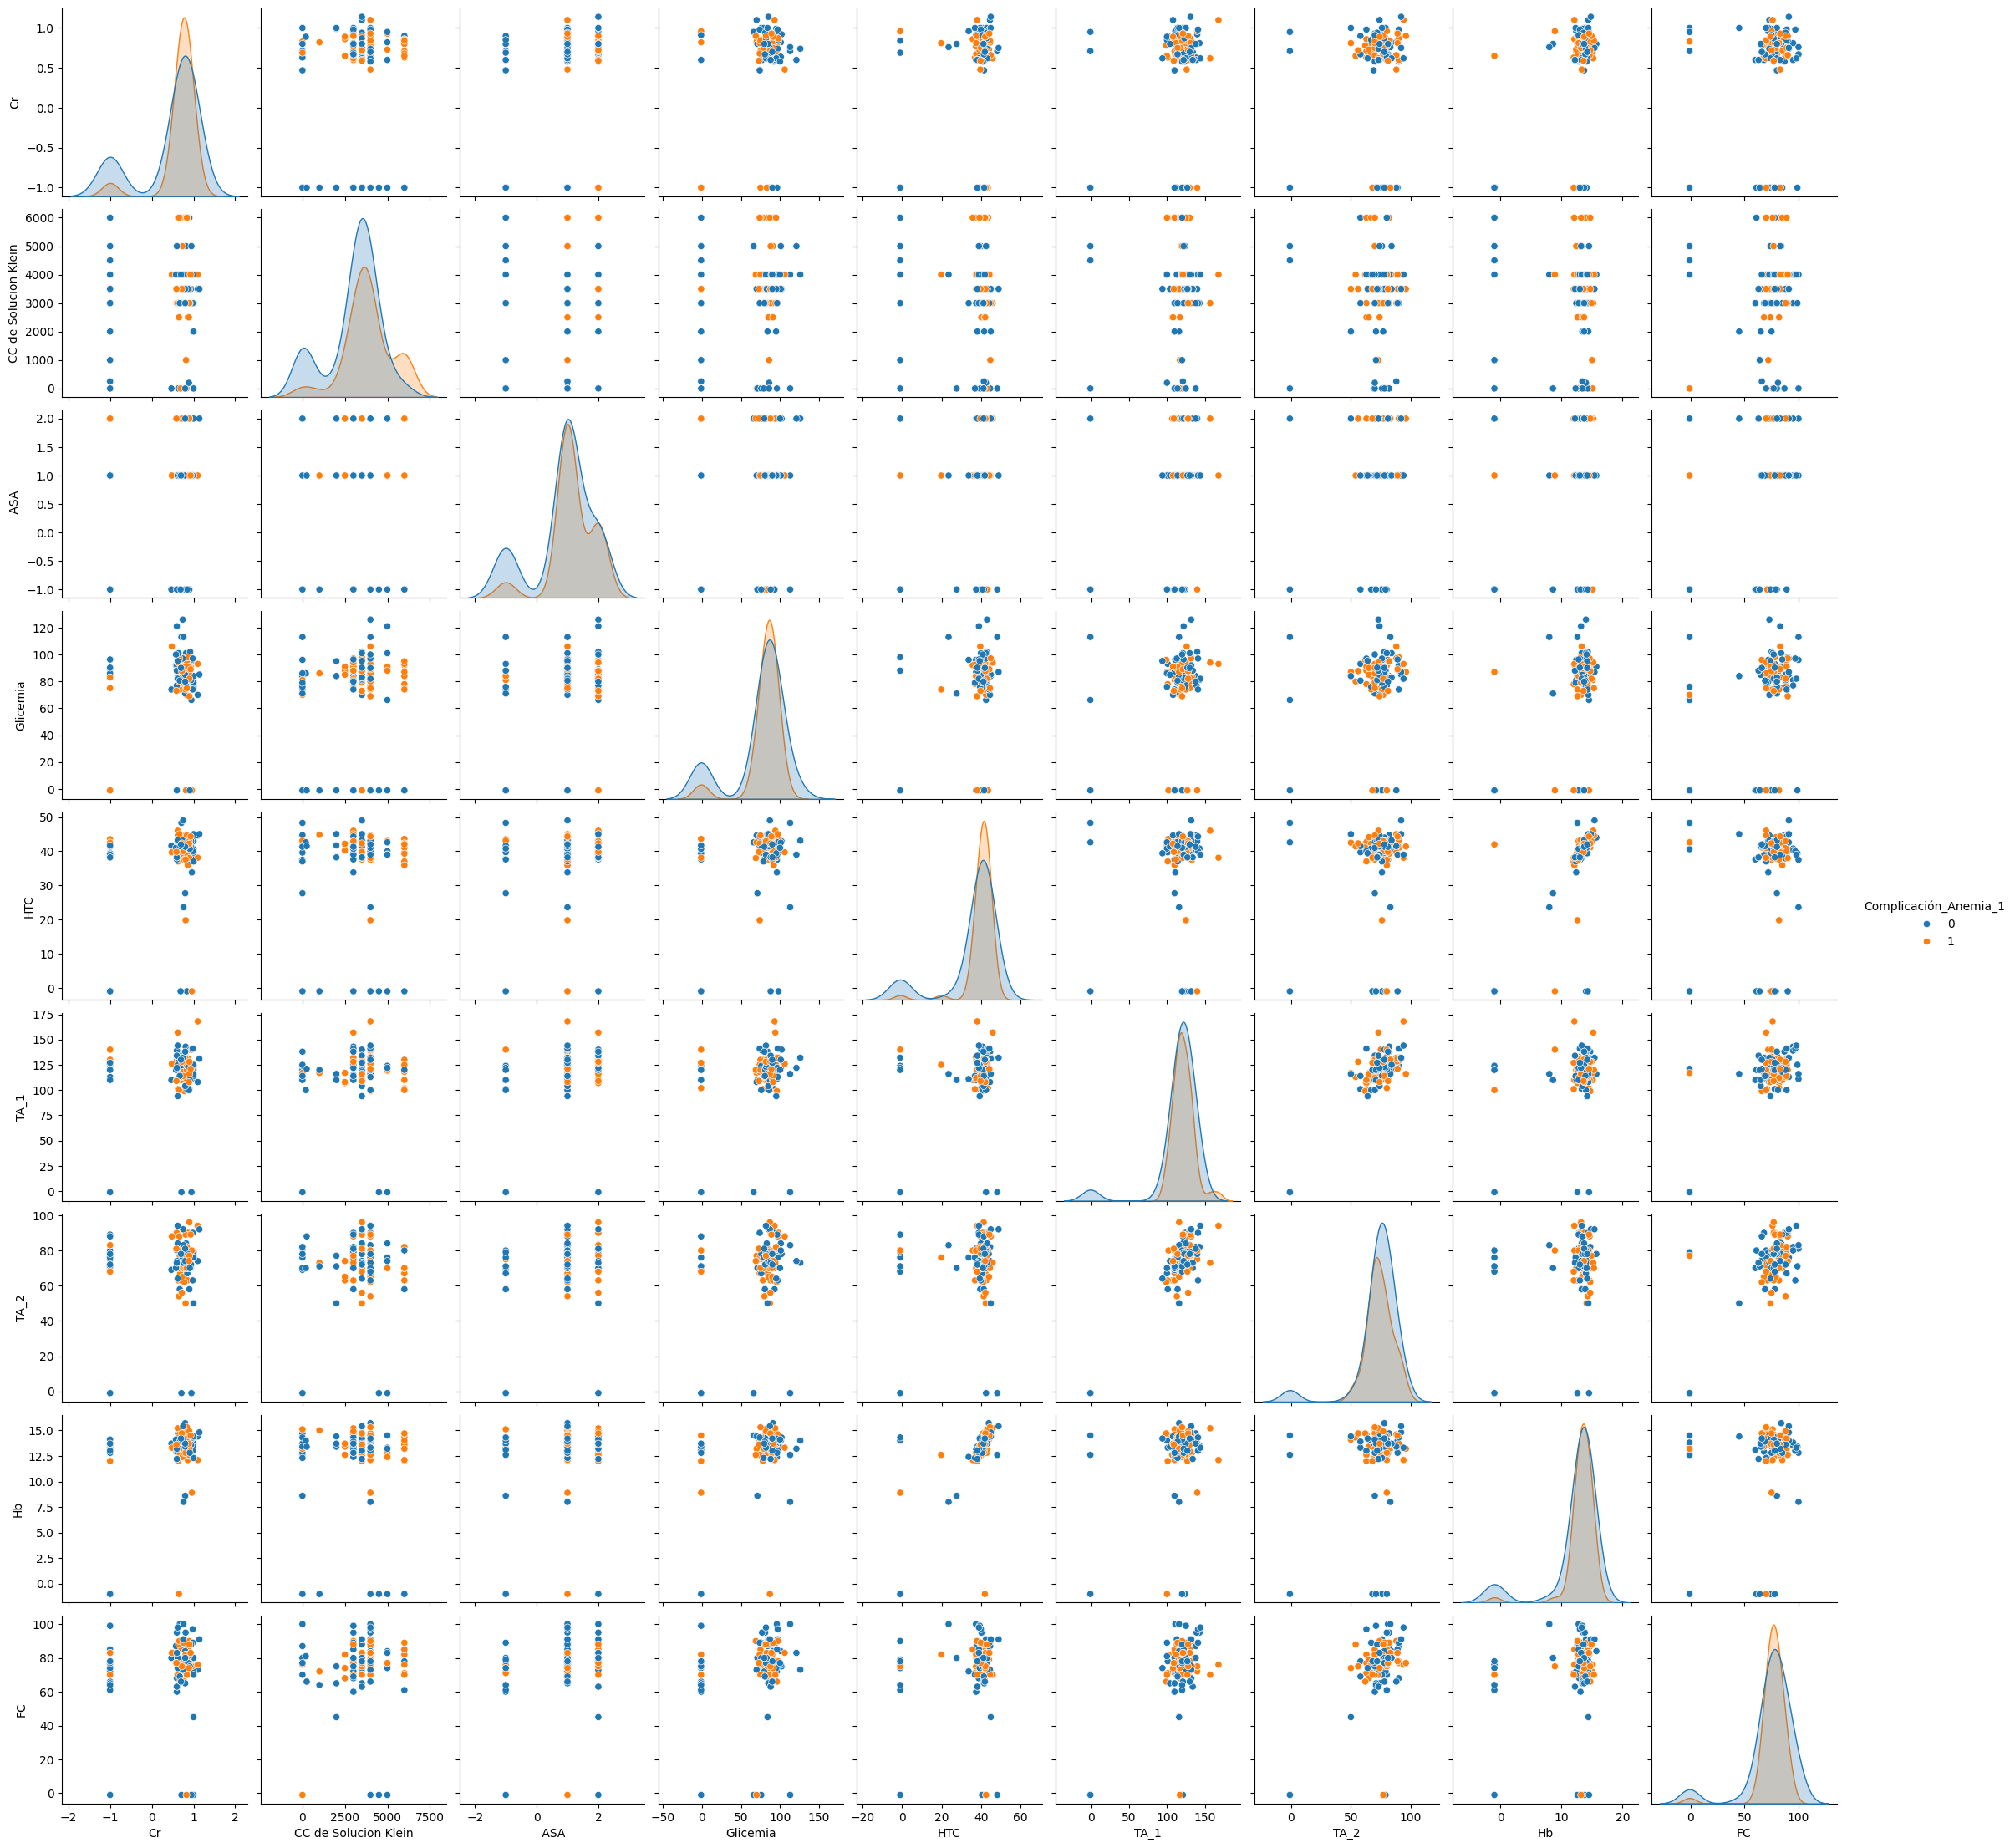

In [ ]:
# Drawing scatterplots for joint relationships and histograms for univariate distributions - 10 features
features_to_pairplot = ['Cr', 'CC de Solucion Klein', ' ASA', 'Glicemia', 'HTC', 'TA_1', 'TA_2', 'Hb', 'FC']
sns.pairplot( df[ np.append(features_to_pairplot, 'Complicación_Anemia_1') ], hue = 'Complicación_Anemia_1');

In [ ]:
# Seleccionar características
X_train_selection = X_train_selection_VT
X_test_selection = X_test_selection_VT

print("Forma de X_train:", X_train_selection.shape)
print("Forma de X_test:", X_test_selection.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (96, 96)
Forma de X_test: (24, 96)
Forma de y_train: (96,)
Forma de y_test: (24,)


## Normalización

In [ ]:
# Normalisation
scaler = preprocessing.StandardScaler().fit(X_train_selection)
norm_x_train = scaler.transform(X_train_selection)
norm_x_test = scaler.transform(X_test_selection)

# Guardar el escalador
#with open('/content/scaler.pkl', 'wb') as f:
#    pickle.dump(scaler, f)

# Deep Neural Network

In [ ]:
# DNN model
seed_dnn = 57
def compose_model(num_features):

    model = Sequential()

    # Input layer
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))

    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 60, kernel_initializer = glorot_uniform(seed=seed_dnn)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.15, seed = seed_dnn))

    # 2. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_2', units = 45, kernel_initializer = glorot_uniform(seed=seed_dnn)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.1, seed = seed_dnn))

    # 3. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_3', units = 30, kernel_initializer = glorot_uniform(seed=seed_dnn)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units=1, kernel_initializer=glorot_uniform(seed=seed_dnn)))
    model.add(layers.Activation('sigmoid'))

    return model

In [ ]:
# Composing model
model = compose_model(X_train_selection.shape[1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormaliza  (None, 96)                384       
 tion)                                                           
                                                                 
 HiddenLayer_1 (Dense)       (None, 60)                5820      
                                                                 
 batch_normalization (Batch  (None, 60)                240       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 60)                0         
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 45)                2

In [ ]:
# Compiling and fitting the model
model.compile(optimizer = Adam(learning_rate=0.0005), loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(norm_x_train, y_train, batch_size = len(norm_x_train), epochs = 200, verbose=0)

In [ ]:
# Guardar el modelo
model.save('/content/modelo.keras')

Training accuracy: 0.9895833134651184


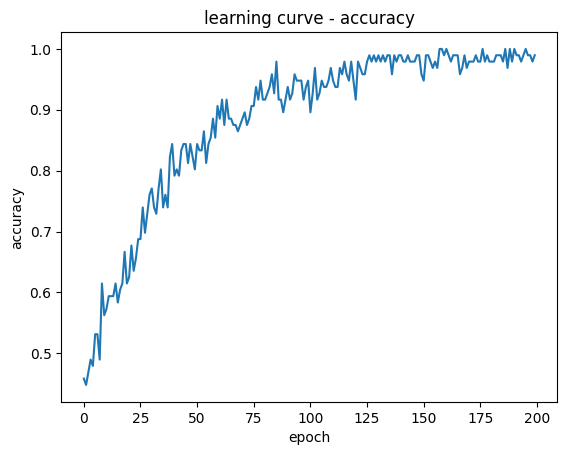


Training loss: 0.11026554554700851


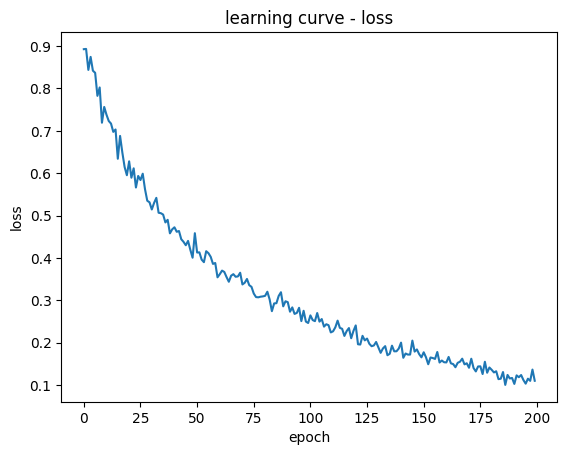

In [ ]:
# Plotting
# Accuracy
print('Training accuracy:', history.history['accuracy'][-1])
plt.plot(history.history['accuracy'])
plt.title('learning curve - accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Loss
print('\nTraining loss:', history.history['loss'][-1])
plt.plot(history.history['loss'])
plt.title('learning curve - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluando el modelo
score = model.evaluate(norm_x_test, y_test, verbose=0)
print('Test accuracy:', score[1])
print('Test loss:', score[0])

# Predicciones binarias con un umbral de 0.5
y_pred_prob = model.predict(norm_x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # True si la probabilidad es mayor o igual a 0.5

# Reporte de clasificación
print("\nNumber of test samples: ", len(y_pred))
print(classification_report(y_test, y_pred))

Test accuracy: 0.9166666865348816
Test loss: 0.42648497223854065
1/1 [==============================] - 0s 130ms/step

Number of test samples:  24
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.80      0.89        10

    accuracy                           0.92        24
   macro avg       0.94      0.90      0.91        24
weighted avg       0.93      0.92      0.91        24



# Predicción

In [ ]:
paciente = [
    80.0,   # FC
    1.0,    # Rango1    {0: Bradicardia, 1: Normal, 2: taquicardia}
    130.0,  # TA_1
    77.0,   # TA_2
    0.0,    # Rango2    {0: Hipertension, 1: Hipotension, 2: Normal}
    -1.0,   # IMC
    -1.0,   # Rango3    {0: Bajo Peso, 1: Normal, 2: Obesidad, 3: Sobrepeso}
    1.0,    # ASA
    1.0,    # Malampatii
    12.7,   # Hb
    1.0,    # Rango4    {0 Anemia: 1 Normal}
    37.7,   # HTC
    1.0,    # Rango5    {0 Anemia: 1 Normal}
    80.0,   # Glicemia
    2.0,    # Rango6    {0: Hiperglicemia, 1: Hipoglicemia, 2: Normal}
    0.67,   # Cr
    1.0,    # Rango7    {0: Alteración Renal, 1: Normal}
    3.0,    # # de CX
    3.0,    # Cirujano  {0: C1, 1: C2, 2: C3, 3: C4, 4: C5, 5: C6, 6: C7, 7: C8, 8: C9, 9: C10, 10: C11}
    3.0,    # Anestesio {0: A1, 1: A2, 2: A3, 3: A4, 4: A5, 5: A6, 6: A7, 7: A8, 8: A9, 9: A10, 10: A11, 11: A12}
    4000.0, # CC de Solucion Klein
    0.0,    # Reintervencion
    2017.0, # Año
    42.0,   # Edad
    5.0,    # Grupo Etario              {0: <20, 1: 20 - 25, 2: 25 - 30, 3: 30 - 35, 4: 35 - 40, 5: 40 - 45, 6: 45 - 50, 7: 50 - 55, 8: 55 - 59, 9: 60 o mas}
    5.0,    # Nacionalidad              {0: Chile, 1: Col, 2: EEUU, 3: Haiti, 4: Italia, 5: Puerto Rico, 6: República Dominicana, 7: USA, 8: Venezuela}
    1.0,    # Gestas previas            {0: G1, 1: G2, 2: G3, 3: G4, 4: G5, 5: G6, 6: G7, 7: G8}
    1.0,    # Antibiotico Profilactico  {0: Cefazolina, 1: Cefradina, 2: Clindamicina}
    1.0,    # Liposuccion
    1.0,    # Abdominoplastia
    1.0,    # Transferencia Glutea
    0.0,    # Mastopexia con/sin implante
    0.0,    # Marcacion Abdominal
    0.0,    # Otras
    0.0,    # Antecedentes personales relevantes_Anemia
    0.0,    # Antecedentes personales relevantes_Ansiedad
    1.0,    # Antecedentes personales relevantes_Asma
    0.0,    # Antecedentes personales relevantes_Ca de Mama
    0.0,    # Antecedentes personales relevantes_DLP
    0.0,    # Antecedentes personales relevantes_Depresion
    0.0,    # Antecedentes personales relevantes_Dermatitis
    0.0,    # Antecedentes personales relevantes_Epilepsia
    0.0,    # Antecedentes personales relevantes_Gastritis
    0.0,    # Antecedentes personales relevantes_Glomerulonefritis
    0.0,    # Antecedentes personales relevantes_HTA
    0.0,    # Antecedentes personales relevantes_Hipotiroidismo
    0.0,    # Antecedentes personales relevantes_Malaria
    0.0,    # Antecedentes personales relevantes_Migraña
    0.0,    # Antecedentes personales relevantes_Miomatosis Uterina
    0.0,    # Antecedentes personales relevantes_Pancreatitis
    1.0,    # Antecedentes personales relevantes_Rinitis
    0.0,    # Antecedentes personales relevantes_SII
    0.0,    # Antecedentes personales relevantes_Sin antecedentes
    0.0,    # Antecedentes personales relevantes_Sindrome Antifosfolipido
    0.0,    # Antecedentes personales relevantes_Tabaquismo
    0.0,    # Antecedentes personales relevantes_Vegana
    0.0,    # Cirugias No Esteticas_Adenoamigdalectomia
    0.0,    # Cirugias No Esteticas_Apendicectomia
    0.0,    # Cirugias No Esteticas_Bypass
    0.0,    # Cirugias No Esteticas_Cesarea
    0.0,    # Cirugias No Esteticas_Colelap
    0.0,    # Cirugias No Esteticas_Fistula anal
    0.0,    # Cirugias No Esteticas_Ganglion
    0.0,    # Cirugias No Esteticas_Herniorrafia
    0.0,    # Cirugias No Esteticas_Hidrlipoclasia
    0.0,    # Cirugias No Esteticas_Histerectomia
    0.0,    # Cirugias No Esteticas_Injerto  de piel
    0.0,    # Cirugias No Esteticas_LES
    0.0,    # Cirugias No Esteticas_Laparoscopia
    0.0,    # Cirugias No Esteticas_Legrado
    0.0,    # Cirugias No Esteticas_Litotripsia
    0.0,    # Cirugias No Esteticas_Marsupializacion
    0.0,    # Cirugias No Esteticas_Osteosintesis
    0.0,    # Cirugias No Esteticas_Peritonitis
    0.0,    # Cirugias No Esteticas_Pieloplastia
    0.0,    # Cirugias No Esteticas_Polipo nasal
    0.0,    # Cirugias No Esteticas_Pterigio
    0.0,    # Cirugias No Esteticas_Quiste de ovario
    0.0,    # Cirugias No Esteticas_Safenectomia
    1.0,    # Cirugias No Esteticas_Sin antecedentes
    0.0,    # Cirugias No Esteticas_Tenorrafia
    0.0,    # Cirugias No Esteticas_Timpanoplastia
    0.0,    # Cirugias No Esteticas_Tubectomia
    0.0,    # Cirugias No Esteticas_Tunel del carpo
    0.0,    # Cirugias No Esteticas_Turbinoplastia
    0.0,    # Cx Esteticas Previas_Abdominoplastia
    0.0,    # Cx Esteticas Previas_Bicheptomia
    0.0,    # Cx Esteticas Previas_Biopolimeros
    0.0,    # Cx Esteticas Previas_Gluteoplastia
    0.0,    # Cx Esteticas Previas_Lipolisis
    0.0,    # Cx Esteticas Previas_Liposuccion
    0.0,    # Cx Esteticas Previas_Lipotransferencia
    0.0,    # Cx Esteticas Previas_Mamoplastia
    0.0,    # Cx Esteticas Previas_Mastopexia
    0.0,    # Cx Esteticas Previas_Rinoplastia
    1.0]    # Cx Esteticas Previas_Sin antecedentes

In [ ]:
# Importar paquetes para predicción
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# Escalar datos de paciente
with open('scaler.pkl', 'rb') as f:                                                 # Cargar el escalador
    loaded_scaler = pickle.load(f)
paciente_normalizado = loaded_scaler.transform( np.array(paciente).reshape(1, -1) ) # Escalando datos del paciente

# Cargar el modelo
modelo = load_model('modelo.keras')

# Ejecutar e imprimir predicción
y_pred_prob = modelo.predict(paciente_normalizado)
print(f"Probabilidad Anemia: { round(float(y_pred_prob[0][0]), 4) * 100 } %")

1/1 [==============================] - 1s 796ms/step
Probabilidad Anemia: 94.23 %
